<a href="https://colab.research.google.com/github/kdambrowski/News_recog_soapBeauti/blob/main/Fake_news_detection_from_url_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Classification with download data form URL module 2

# README
 Presenting project is continuation of Fake News Classification with download data form URL module 1

**Fake_news_detection_from_url_modeling which does contains:**
 1. Modeling
 2. Tune results
 3. Visualizations

# Library

In [1]:
!pip install joblib

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import csv
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from bs4 import BeautifulSoup
import os
from imblearn.combine import SMOTEENN
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from pathlib import Path
from tqdm import tqdm, tqdm_notebook
import torch.optim as optim
from sklearn.decomposition import TruncatedSVD
import joblib

# Classess and functions

In [3]:
def display_class_pie_distribution(ds, label_col_name):
    class_names = {0: 'FAKE', 1: 'NEWS'} # słownik przypisujący etykiety do wartości klas
    class_counts = ds[label_col_name].value_counts(normalize=True).to_dict()
    class_labels = [class_names[k] for k in class_counts.keys()] # mapowanie wartości klas na etykiety
    plt.pie(class_counts.values(),
            labels=class_labels, # używanie etykiet zamiast wartości klas
            autopct='%1.2f%%')
    plt.title(f'{label_col_name} distribution')
    plt.show()

def text_low_standarization(ds):
  for col in ds.select_dtypes('object'):
    ds.loc[:,(col)] = ds.loc[:,(col)].astype('string')
    ds.loc[:,(col)]= ds.loc[:,(col)].apply(lambda x: x.lower())
  return ds

def display_class_pie_distribution(ds, label_col_name):
  plt.pie(ds[label_col_name].value_counts(normalize=True),
          labels=set(ds[label_col_name]),
          autopct='%1.2f%%')
  plt.title(f'{label_col_name} distribution')
  plt.show()

def min_column_len_filter(ds, col, length):
  len_filter = ds[col].str.len()>length
  ds = ds[len_filter]
  return ds

def is_null_filter(ds):
  is_null_filter = ds.isnull().sum(axis=1).astype(bool)
  return is_null_filter

def ds_wo_null(ds):
  filter = is_null_filter(ds)
  ds= ds[~filter]
  return ds

def result_m(ds, text_column_name, nfx, list_of_nfx_methods):
    for stuff in dir(nfx):
      for method in list_of_nfx_methods:
        if stuff == method:
          ds[[text_column_name]] = ds[[text_column_name]].apply(stuff)
    return ds

In [4]:
class NLP_Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.Linear(1500, 180)
        self.relu = nn.ReLU()
        self.output = nn.Linear(180, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.relu(self.hidden(x))
        x = self.sigmoid(self.output(x))
        return x


class BinaryClassification(nn.Module):
    def __init__(self):
        super(BinaryClassification, self).__init__()
        self.layer_1 = nn.Linear(1500, 64)
        self.layer_2 = nn.Linear(64, 64)
        self.layer_out = nn.Linear(64, 1)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.1)
        self.batchnorm1 = nn.BatchNorm1d(64)
        self.batchnorm2 = nn.BatchNorm1d(64)

    def forward(self, inputs):
        x = self.relu(self.layer_1(inputs))
        x = self.batchnorm1(x)
        x = self.relu(self.layer_2(x))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = self.layer_out(x)
        return x

class NLPModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers=1, dropout=0.1):
        super(NLPModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, bidirectional=True, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, inputs):
        embed = self.embedding(inputs)
        lstm_out, _ = self.lstm(embed)
        logits = self.fc(lstm_out[:, -1, :])
        return logits.squeeze()

class Vect_Word_Dataset(Dataset):
    def __init__(self, words_vect, labels):
        self.words = words_vect
        self.labels = labels

    def __getitem__(self, idx):
        vect = self.words[idx]
        label = self.labels[idx]
        return vect, label

    def __len__(self):
        return len(self.words)


def get_dataloader(vect_words,
                         labels,
                         batch_size = 32,
                         shuffle=True,
                         num_workers = 2):
    dataset = Vect_Word_Dataset(vect_words, labels)
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            num_workers = num_workers)
    return dataloader

def train_test_pt_model(model,
                        train_loader,
                        test_loader,
                        criterion,
                        optimizer,
                        epochs = 10):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  train_losses = []
  train_accs = []
  epochs_loop = []

  test_losses = []
  test_epoch_acc = []
  for epoch in range(epochs):
      progress_bar = tqdm_notebook(train_loader, leave=False)
      batch_losses = []
      test_batch_losses = []
      epochs_loop.append(epoch+1)
      acc, count, test_acc, test_count = 0, 0, 0, 0
      model.train()
      for inputs, target in progress_bar:
          inputs.view(inputs.shape[0], -1)
          inputs = inputs.to(device)
          target = target.to(device)

          model.zero_grad()
          output = model(inputs)
          loss = criterion(output.squeeze(), target.float())
          loss.backward()
          nn.utils.clip_grad_norm_(model.parameters(), 3)
          optimizer.step()
          progress_bar.set_description(f'Epoch: {epoch+1}\nLoss: {loss.item():.3f}')
          batch_losses.append(loss.item())

          pred_proba = torch.sigmoid(output)
          pred = torch.where(pred_proba>0.5, 1,0).squeeze()
          acc += (pred == target).sum()
          count += len(target)

      model.eval()
      with torch.inference_mode():
        for test_input, test_target in test_loader:
          inputs.view(inputs.shape[0], -1)
          test_input = test_input.to(device)
          test_target = test_target.to(device)

          test_out = model(test_input).squeeze()
          test_pred = torch.round(torch.sigmoid(test_out))
          test_loss = criterion(test_out, test_target.float())
          test_batch_losses.append(test_loss.item())
          test_acc += (test_pred == test_target).sum()
          test_count += len(test_target)


      epoch_loss = sum(batch_losses) / len(batch_losses)
      train_losses.append(epoch_loss)
      epoch_acc = (acc / count) * 100
      train_accs.append(epoch_acc.item())

      test_epoch_loss = sum(test_batch_losses) / len(test_batch_losses)
      test_losses.append(test_epoch_loss)
      epoch_test_acc = (test_acc / test_count) * 100
      test_epoch_acc.append(epoch_test_acc.item())

      if not epoch % 10:
        tqdm.write(f'Epoch #{epoch + 1}\tTrain Loss: {epoch_loss:.5f} \tTrain ACC: {epoch_acc:.5f}')
        tqdm.write(f'Epoch #{epoch + 1}\tTest Loss: {test_epoch_loss:.5f} \tTest ACC: {epoch_test_acc:.5f}\n')
  return train_losses, train_accs, test_losses, test_epoch_acc, epochs_loop

def draw_test_train_plot(train_losse, train_acc, test_loss = None, test_acc = None):
  epoch_range = range(1, len(train_losse)+1)
  acc_color = 'r'
  loss_color = 'b'
  if test_acc is not None and test_loss is not None:
    fig, ax = plt.subplots(2,1, sharex = True)
    ax[0].set_title('Train_test LOSS and ACC plot throu trainings epochs')
    ax[0].plot(epoch_range, train_losse, label = 'train_loss', color = loss_color)
    ax[0].plot(epoch_range, test_loss, label = 'test_loss', color = loss_color, linestyle = '--')
    ax[0].set_ylabel('Loss value')
    ax[0].legend()

    ax[1].plot(epoch_range, train_acc, label = 'train_acc',  color = acc_color)
    ax[1].plot(epoch_range, test_acc, label = 'test_acc',  color = acc_color, linestyle = '--')
    ax[1].set_xlabel('epochs')
    ax[1].set_ylabel('ACC value')
    ax[1].legend()
  else:
    fig, ax = plt.subplots()
    plt.title('Train LOSS and ACC plot through trainings epochs')
    ax.plot(epoch_range, train_losses, label = 'train_loss', color = loss_color)
    ax.set_xlabel('epochs')
    ax.set_ylabel('Loss value')

    ax2=ax.twinx()
    ax2.plot(epoch_range, train_acc, label = 'train_acc', color = acc_color)

    ax2.set_ylabel('ACC value')
    ax2.tick_params('y', colors = acc_color)
    ax.legend()
    ax2.legend()

  plt.show()

def save_model(model, dic_name, model_name):
    MODEL_PATH = Path(dic_name)
    MODEL_PATH.mkdir(parents = True, exist_ok = True)
    MODEL_SAVE_PATH = MODEL_PATH / (model_name + '.pth')
    torch.save(model.state_dict(), MODEL_SAVE_PATH)
    status = f'Model has been saved to: {MODEL_SAVE_PATH}'
    print(status)
    return str(MODEL_SAVE_PATH)

def load_model(model_class, saved_model_path):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  loaded_model = model_class
  loaded_model.load_state_dict(torch.load(saved_model_path))
  loaded_model.to(device)
  print(f"Loaded model structure:\n{loaded_model}\n\nModel on device:\n{next(loaded_model.parameters()).device}")
  return loaded_model

# Variables

In [5]:
""" This file is a product of preprocessing module 1,
and it contains the path to my data source,
which was prepared during the process of module 1.
If you have your DS from running module 1 paste path between single quotes.
There is path to prepared DF
'https://drive.google.com/file/d/1uptv4KepTEHSsQe1ZQfeYxqoBZhT5OvM/view?usp=drive_link' """

df = pd.read_pickle('/content/after_std_1.pkl')

# Modeling

# Linear regression

In [6]:
X = df['clean_text']
y = df['is_real_news']

tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(X)

svd = TruncatedSVD(n_components=1500)
X_tfidf_svd = svd.fit_transform(X_tfidf)

smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_tfidf_svd, y)
df_resampled = pd.DataFrame(X_resampled, columns=[f'feature_{i}' for i in range(1500)])
df_resampled['is_real_news'] = y_resampled


In [7]:
X_train, X_test, y_train, y_test = train_test_split(df_resampled.drop('is_real_news', axis=1),
                                                    df_resampled['is_real_news'],
                                                    test_size=0.2, random_state=42)


In [8]:
for df in [X_train, X_test, y_train, y_test ]:
  print(df.shape)

(19684, 1500)
(4922, 1500)
(19684,)
(4922,)


In [9]:

log_reg = LogisticRegression(max_iter=10_000)
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      2423
           1       1.00      0.96      0.98      2499

    accuracy                           0.98      4922
   macro avg       0.98      0.98      0.98      4922
weighted avg       0.98      0.98      0.98      4922



## DL PyTorch simple model

In [10]:
train_tensor_label= torch.Tensor(np.array(y_train))
train_X_tensor = torch.Tensor(np.array(X_train))
dataloader = get_dataloader(train_X_tensor,
                                  train_tensor_label,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=2)


test_tensor_label = torch.Tensor(np.array(y_test))
test_tensor_vect = torch.Tensor(np.array(X_test))
test_loader = get_dataloader(test_tensor_vect,
                                   test_tensor_label,
                                   batch_size=32,
                                   shuffle=True,
                                   num_workers=2)

pt_model = NLP_Net()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pt_model.parameters(), lr=0.001)



train_losses, train_accs, test_losses, test_epoch_acc, _ = train_test_pt_model(pt_model,
                                                                            dataloader,
                                                                            test_loader,
                                                                            criterion,
                                                                            optimizer,
                                                                            epochs = 70)

<ipython-input-4-46aff182eaa0>:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.54526 	Train ACC: 49.80695
Epoch #1	Test Loss: 0.50809 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.50605 	Train ACC: 54.98883
Epoch #11	Test Loss: 0.50366 	Test ACC: 56.35920



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.50588 	Train ACC: 71.42857
Epoch #21	Test Loss: 0.50369 	Test ACC: 71.61723



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #31	Train Loss: 0.50598 	Train ACC: 81.22841
Epoch #31	Test Loss: 0.50384 	Test ACC: 78.44373



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #41	Train Loss: 0.50581 	Train ACC: 85.55680
Epoch #41	Test Loss: 0.50369 	Test ACC: 86.79399



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #51	Train Loss: 0.50567 	Train ACC: 95.75289
Epoch #51	Test Loss: 0.50370 	Test ACC: 97.05405



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #61	Train Loss: 0.50565 	Train ACC: 97.89169
Epoch #61	Test Loss: 0.50368 	Test ACC: 98.04958



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

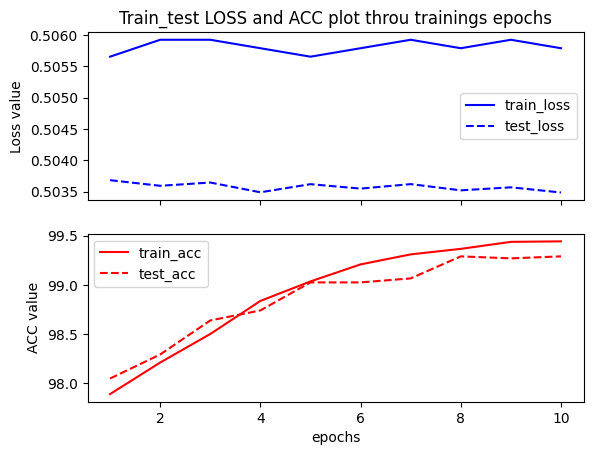

In [11]:
n = -10
draw_test_train_plot(train_losses[n:], train_accs[n:], test_losses[n:], test_epoch_acc[n:])

## DL PyTorch advanced model

In [12]:
train_tensor_label= torch.Tensor(np.array(y_train))
train_X_tensor = torch.Tensor(np.array(X_train))
dataloader = get_dataloader(train_X_tensor,
                                  train_tensor_label,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=2)


test_tensor_label = torch.Tensor(np.array(y_test))
test_tensor_vect = torch.Tensor(np.array(X_test))
test_loader = get_dataloader(test_tensor_vect,
                                   test_tensor_label,
                                   batch_size=32,
                                   shuffle=True,
                                   num_workers=2)

complex_pt_model = BinaryClassification()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pt_model.parameters(), lr=0.001)



train_losses, train_accs, test_losses, test_epoch_acc, _ = train_test_pt_model(complex_pt_model,
                                                                            dataloader,
                                                                            test_loader,
                                                                            criterion,
                                                                            optimizer,
                                                                            epochs = 80)

<ipython-input-4-46aff182eaa0>:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.77538 	Train ACC: 42.30847
Epoch #1	Test Loss: 0.76710 	Test ACC: 41.67006



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.77527 	Train ACC: 41.95285
Epoch #11	Test Loss: 0.78687 	Test ACC: 40.34945



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.77405 	Train ACC: 41.94270
Epoch #21	Test Loss: 0.77579 	Test ACC: 40.12597



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #31	Train Loss: 0.77513 	Train ACC: 42.26275
Epoch #31	Test Loss: 0.77696 	Test ACC: 40.75579



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #41	Train Loss: 0.77454 	Train ACC: 42.22719
Epoch #41	Test Loss: 0.77623 	Test ACC: 40.32914



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #51	Train Loss: 0.77494 	Train ACC: 42.11542
Epoch #51	Test Loss: 0.76628 	Test ACC: 42.15766



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #61	Train Loss: 0.77547 	Train ACC: 42.03414
Epoch #61	Test Loss: 0.77792 	Test ACC: 40.00406



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #71	Train Loss: 0.77316 	Train ACC: 42.07986
Epoch #71	Test Loss: 0.77216 	Test ACC: 40.22755



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

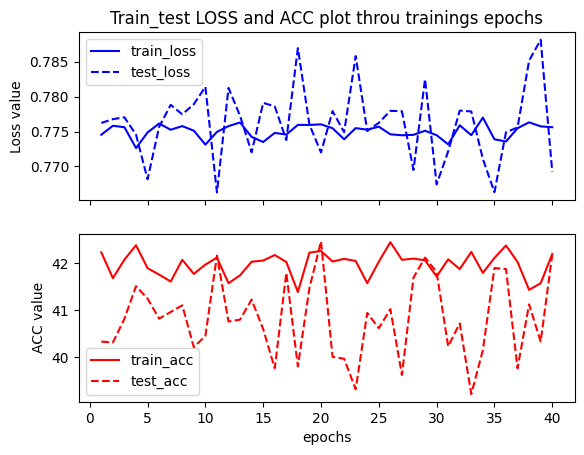

In [13]:
n = 40
draw_test_train_plot(train_losses[n:], train_accs[n:], test_losses[n:], test_epoch_acc[n:])

In [14]:
train_tensor_label = torch.Tensor(np.array(y_train))
train_X_tensor = torch.LongTensor(np.array(X_train))
dataloader = get_dataloader(train_X_tensor,
                                  train_tensor_label,
                                  batch_size=32,
                                  shuffle=True,
                                  num_workers=2)

test_tensor_label = torch.Tensor(np.array(y_test))
test_tensor_vect = torch.LongTensor(np.array(X_test))
test_loader = get_dataloader(test_tensor_vect,
                                   test_tensor_label,
                                   batch_size=32,
                                   shuffle=True,
                                   num_workers=2)


nlp_model = NLPModel(1500, 100, 150)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(pt_model.parameters(), lr=0.001)



train_losses, train_accs, test_losses, test_epoch_acc, _ = train_test_pt_model(nlp_model,
                                                                            dataloader,
                                                                            test_loader,
                                                                            criterion,
                                                                            optimizer,
                                                                            epochs = 80)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
<ipython-input-4-46aff182eaa0>:90: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  progress_bar = tqdm_notebook(train_loader, leave=False)


  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #1	Train Loss: 0.69316 	Train ACC: 49.80695
Epoch #1	Test Loss: 0.69311 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #11	Train Loss: 0.69316 	Train ACC: 49.80695
Epoch #11	Test Loss: 0.69311 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #21	Train Loss: 0.69316 	Train ACC: 49.80695
Epoch #21	Test Loss: 0.69311 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #31	Train Loss: 0.69316 	Train ACC: 49.80695
Epoch #31	Test Loss: 0.69311 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #41	Train Loss: 0.69316 	Train ACC: 49.80695
Epoch #41	Test Loss: 0.69311 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #51	Train Loss: 0.69316 	Train ACC: 49.80695
Epoch #51	Test Loss: 0.69311 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #61	Train Loss: 0.69316 	Train ACC: 49.80695
Epoch #61	Test Loss: 0.69311 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

Epoch #71	Train Loss: 0.69316 	Train ACC: 49.80695
Epoch #71	Test Loss: 0.69311 	Test ACC: 50.77205



  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

  0%|          | 0/616 [00:00<?, ?it/s]

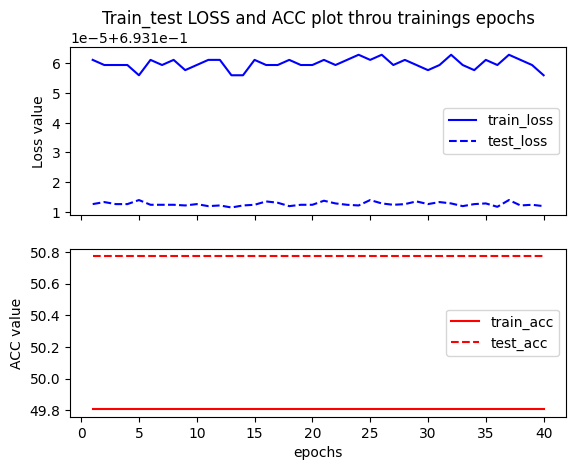

In [15]:
n = 40
draw_test_train_plot(train_losses[n:], train_accs[n:], test_losses[n:], test_epoch_acc[n:])

## Save the best model

In [16]:
joblib.dump(pt_model, 'NLP_Net.pkl')
# log_reg_loaded = joblib.load('log_reg_model.pkl')

['NLP_Net.pkl']